In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

from forceClass import Forces
from forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
# Initial Parameters

# location of the data
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/Carangiform Data/carangiform_amp_2_00_k_1_00'
# location of figures
figure_location = r'../../figures'

# Flags to handle data correctly
force_flag = 1
forceBin_flag = 1

# locations locations if mutliple locations
force_locations = np.array(['force_total', 'forces_top', 'forces_bottom'])

# cycle information
total_cycles = 4
averaged_cycles = 3

# density of the fluid
density = 1025
# viscosity of the fluid
kinVisc = 1.31e-6

# dynamic parameters for fish
# coefficients for motion
c1, c2 = (-0.825, 1.625)
# wavenumber
lam = 1.0
k = 2 * np.pi / lam
# tail amplitude
amp = 0.1
# omega's related to strouhal
omega = np.array([1.571, 3.142, 7.854, 15.708, 23.562, 31.416])
# fluid Velocity
U = 1.0
# strouhal numbers tested
st = (2*amp)*(omega/(2*np.pi))/U

# Reynolds numbers tested
Re = np.array([4e2, 4e3, 4e4, 4e5, 4e6, 4e7, 1e8])


In [4]:
force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()


if force_flag == 1:
    # get the individual cases
    cases = []
    force_case = force_paths[0].parts[-7]
    cases.append(force_case)
    for force_file in force_paths:
        if force_file.parts[-7] != force_case:
            cases.append(force_file.parts[-7])
            force_case = force_file.parts[-7]

    # make a nice dict of all the file names based on parent case
    force_caseDict = dict()
    for case in cases:
        force_caseDict[case] = {}
        for location in force_locations:
            force_caseDict[case][location] = []
            for force_file in force_paths:
                if force_file.parts[-7] == case and force_file.parts[-3] == location:
                    force_caseDict[case][location].append(force_file)

if forceBin_flag == 1:
    # get the individual cases
    cases = []
    forceBin_case = forceBins_paths[0].parts[-7]
    cases.append(forceBin_case)
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-7] != forceBin_case:
            cases.append(forceBins_file.parts[-7])
            forceBin_case = forceBins_file.parts[-7]

    # make a nice dict of all the file names based on parent case
    forceBin_caseDict = dict()
    for case in cases:
        forceBin_caseDict[case] = {}
        for location in force_locations:
            forceBin_caseDict[case][location] = []
            for forceBins_file in forceBins_paths:
                if forceBins_file.parts[-7] == case and forceBins_file.parts[-3] == location:
                    forceBin_caseDict[case][location].append(forceBins_file)

In [7]:
force_paths_total = []

if force_flag == 1:
    for case in force_caseDict:
        for path in force_caseDict[case][force_locations[0]]:
            force_paths_total.append(path)
    forces = [Forces(force_path, averaged_cycles, total_cycles, True, True, 'blackman', 21) for force_path in force_paths_total]

No handles with labels found to put in legend.


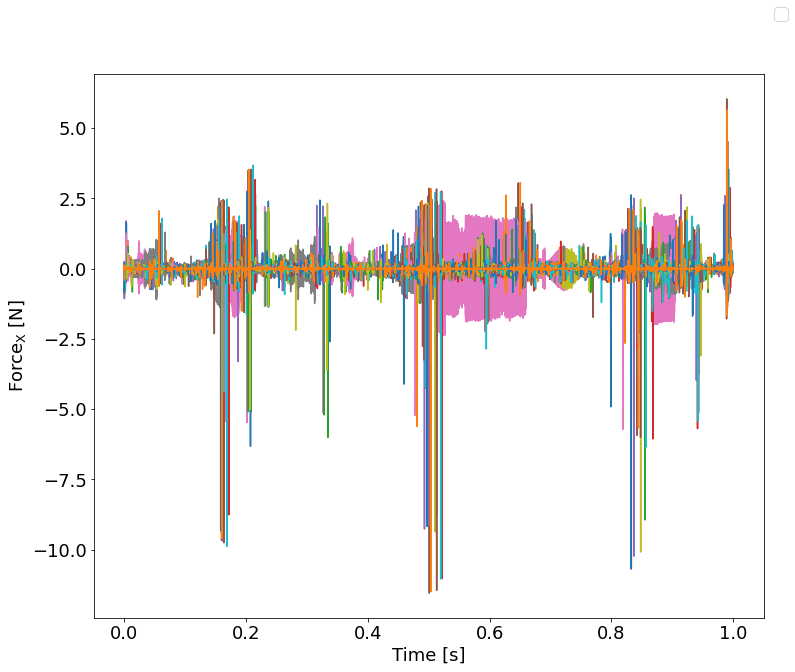

In [8]:
plt.rcParams.update({'font.size':18})

fig1, ax1 = plt.subplots(figsize=(12,10))
for force in forces:
    ax1.plot(force.filteredForces['time']/force.filteredForces['time'][-1], force.filteredForces['total']['x']/density)

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('$\mathrm{Force_X}$ [N]')
ax1.legend(ncol=4, bbox_to_anchor=(1.05, 1.14))
#fig1.savefig(Path(figure_location).joinpath('AvgPower_St.png'))


In [9]:
forceBin_paths_top = []
forceBin_paths_bottom = []

if forceBin_flag == 1:
    for case in forceBin_caseDict:
        for path in forceBin_caseDict[case][force_locations[1]]:
            forceBin_paths_top.append(path)
        for path in forceBin_caseDict[case][force_locations[2]]:
            forceBin_paths_bottom.append(path)    

forceBins_top = [ForceBins(forceBin_path, averaged_cycles, total_cycles, True, True, 'hanning', 11) for forceBin_path in forceBin_paths_top]
forceBins_bottom = [ForceBins(forceBin_path, averaged_cycles, total_cycles, True, True, 'hanning', 11) for forceBin_path in forceBin_paths_bottom]

In [ ]:
print(forceBins_top[0].filteredForces['time'].shape)
print(forceBins_top[0].filteredForces[1]['pressure']['x'].shape)

(28030,)
(28070,)


In [ ]:
for forceBin in forceBins_top:
    if forceBin.specific_case == 'st0_05':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[0], k)
    elif forceBin.specific_case == 'st0_10':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[1], k)
    elif forceBin.specific_case == 'st0_25':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[2], k)
    elif forceBin.specific_case == 'st0_50':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[3], k)
    elif forceBin.specific_case == 'st0_75':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[4], k)
    elif forceBin.specific_case == 'st1_00':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[5], k)

for forceBin in forceBins_bottom:
    if forceBin.specific_case == 'st0_05':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[0], k)
    elif forceBin.specific_case == 'st0_10':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[1], k)
    elif forceBin.specific_case == 'st0_25':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[2], k)
    elif forceBin.specific_case == 'st0_50':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[3], k)
    elif forceBin.specific_case == 'st0_75':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[4], k)
    elif forceBin.specific_case == 'st1_00':
        forceBin.calcPowerCarangiform(density, np.array([amp, c1, c2]), omega[5], k)

ValueError: operands could not be broadcast together with shapes (28070,) (28030,) 

In [ ]:
average_power_dict = dict()
for case in forceBin_caseDict:
    average_power_dict[case] = {force_locations[1]:[], force_locations[2]:[], 'combined':[]}
    for forceBin in forceBins_top:
        if forceBin.parent_case == case:
            average_power_dict[case][force_locations[1]].append(forceBin.average_power)
    for forceBin in forceBins_bottom:
        if forceBin.parent_case == case:
            average_power_dict[case][force_locations[2]].append(forceBin.average_power)

    average_power_dict[case]['combined'] = np.array(average_power_dict[case][force_locations[1]]) + np.array(average_power_dict[case][force_locations[2]])

average_force_dict = dict()
for case in forceBin_caseDict:
    average_force_dict[case] = []
    for force in forces:
        if force.parent_case == case:
            average_force_dict[case].append(force.averageFilteredForces['total']['x']/density)

In [ ]:
average_power_fit = {}
average_force_fit = {}
zero_strouhal = {}

for case in forceBin_caseDict:
    average_power_fit[case] = {}
    average_force_fit[case] = {}
    
    case_power_fit, case_power_r_squared = fit_data(st, np.array(average_power_dict[case]['combined']))
    average_power_fit[case]['fit'] = case_power_fit
    average_power_fit[case]['r-squared'] = case_power_r_squared

    case_force_fit, case_force_r_squared = fit_data(np.array(average_force_dict[case]), st)
    average_force_fit[case]['fit'] = case_force_fit
    average_force_fit[case]['r-squared'] = case_force_r_squared
 
    zero_strouhal[case] = power_law(0, *case_force_fit)

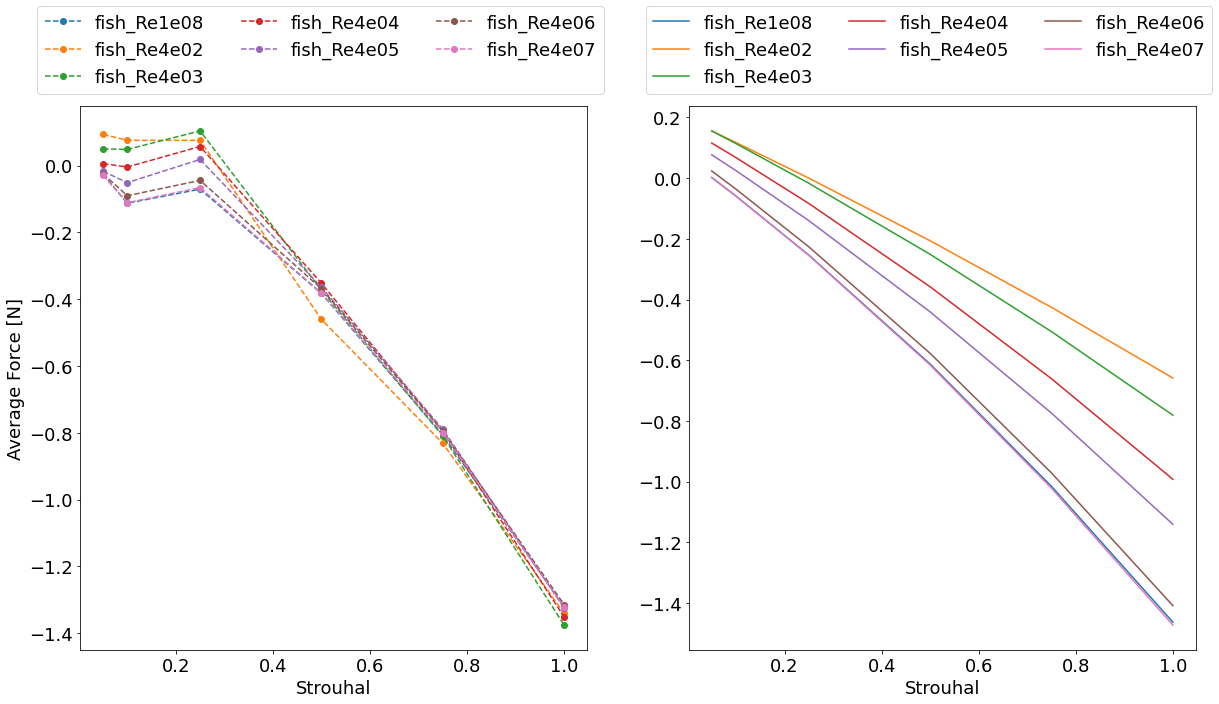

In [ ]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for case in average_power_dict:
    ax1.plot(st, average_force_dict[case], 'o--', label = case)
    ax2.plot(st, power_law(st, *average_force_fit[case]['fit']), label = case)

ax1.set_xlabel('Strouhal')
ax2.set_xlabel('Strouhal')
ax1.set_ylabel('Average Force [N]')
ax1.legend(ncol=3, bbox_to_anchor=(1.05, 1.2))
ax2.legend(ncol=3, bbox_to_anchor=(1.05, 1.2))
#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

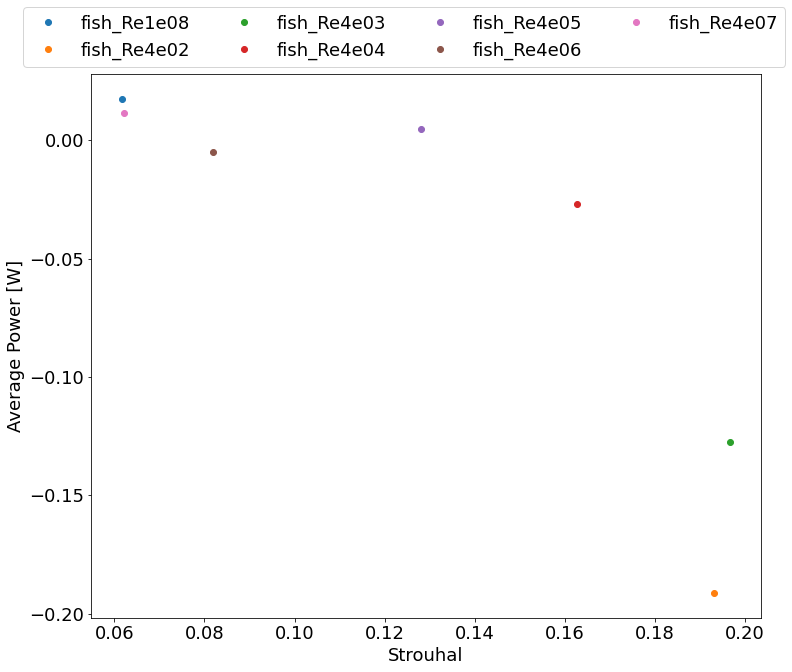

In [ ]:
fig3, ax3 = plt.subplots(figsize=(12,10))
for case in average_power_dict:
    ax3.plot(zero_strouhal[case], power_law(zero_strouhal[case], *average_power_fit[case]['fit']), 'o', label = case)

ax3.set_xlabel('Strouhal')
ax3.set_ylabel('Average Power [W]')
ax3.legend(ncol=4, bbox_to_anchor=(1.05, 1.14))
#fig3.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

Text(0, 0.5, 'Average Power [W]')

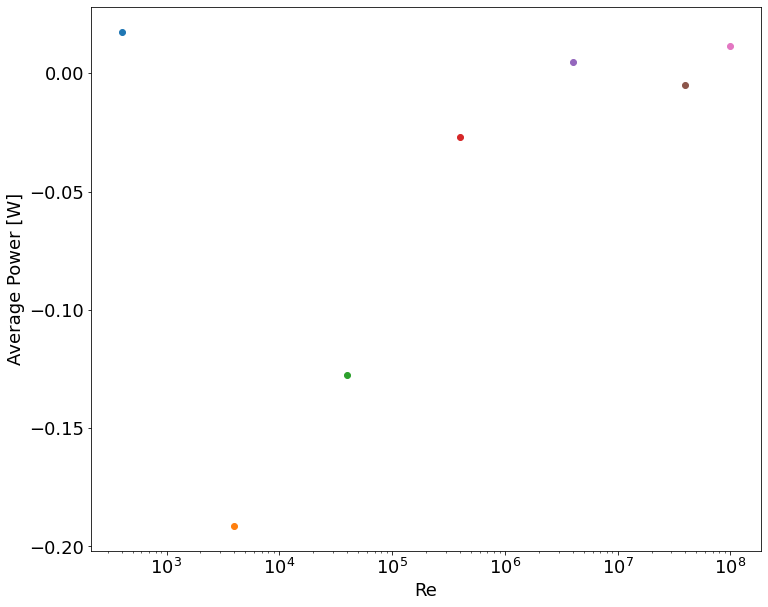

In [ ]:
fig4, ax4 = plt.subplots(figsize=(12,10))
for i, case in enumerate(forceBin_caseDict):
    ax4.plot(Re[i], power_law(zero_strouhal[case], *average_power_fit[case]['fit']), 'o')

ax4.set_xscale('log')
ax4.set_xlabel('Re')
ax4.set_ylabel('Average Power [W]')
#fig4.savefig(Path(figure_location).joinpath('AvgPower_Re.png'))

Text(0, 0.5, 'St')

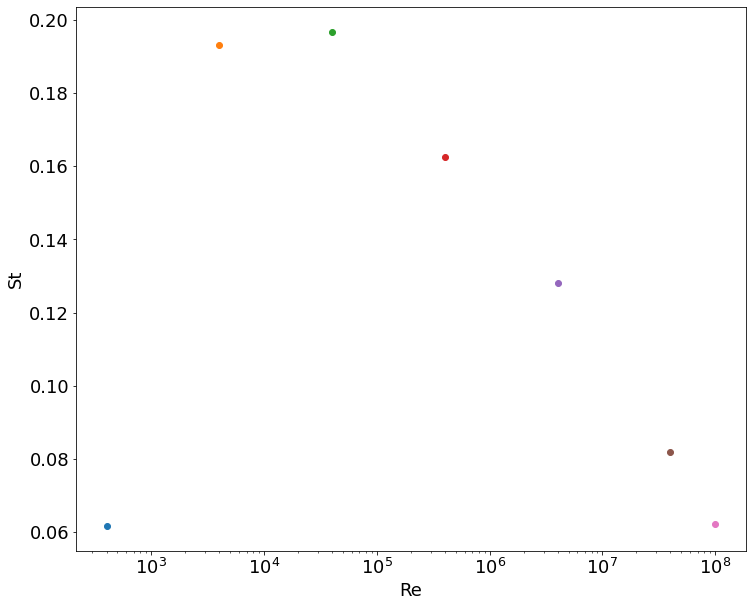

In [ ]:
fig5, ax5 = plt.subplots(figsize=(12,10))
for i, case in enumerate(forceBin_caseDict):
    ax5.plot(Re[i], zero_strouhal[case], 'o')

ax5.set_xscale('log')
ax5.set_xlabel('Re')
ax5.set_ylabel('St')
#fig5.savefig(Path(figure_location).joinpath('Re_St.png'))

Text(0, 0.5, 'Re')

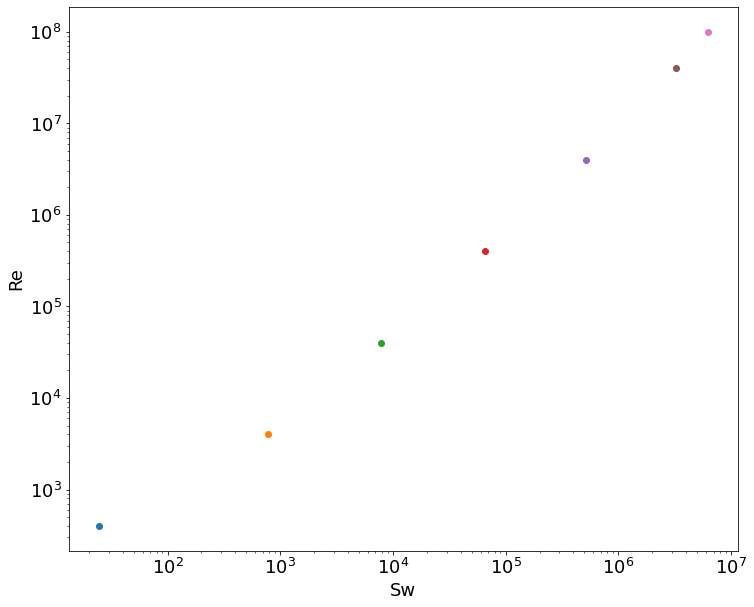

In [ ]:
fig6, ax6 = plt.subplots(figsize=(12,10))
for i, case in enumerate(forceBin_caseDict):
    Sw = zero_strouhal[case] * Re[i]
    ax6.plot(Sw, Re[i], 'o')

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('Sw')
ax6.set_ylabel('Re')
#fig6.savefig(Path(figure_location).joinpath('Sw_Re.png'))

In [ ]:
print(average_power_dict['fish_Re4e04'])
print(average_force_dict['fish_Re4e04'])

{'forces_top': [-0.02600541816073755, 0.2218938495088532, -0.35711269894266967, 0.23337922103478964, 0.5883142101611539, 0.9262331292016456], 'forces_bottom': [0.02701818783210937, -0.2651894406718527, 0.45461713270095383, -0.46803701157493555, -0.7653253464457214, -1.0416988522082515], 'combined': array([ 0.00101277, -0.04329559,  0.09750443, -0.23465779, -0.17701114,
       -0.11546572])}
[0.006354467275345533, -0.004013883650205412, 0.05742318229614889, -0.35209140112932713, -0.7953974746959821, -1.3513944524651527]
